# **Deep Learning Fault Segmentation using Real Seismic Data**

by : leocd91@gmail.com

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/1e4TVfS_IjOnho2FASVGir8knAND6qe34?usp=sharing">
        <img src="https://i.ibb.co/3723Hm9/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/leocd91/geoscience-ML-tutorial/tree/main">
        <img src="https://i.ibb.co/L5p10GH/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# **Introduction**


---
Welcome to the second episode of "***Geoscience ML Tutorial***" Series.

I made this tutorial as beginner-friendly as possible.
And some code are not *pythonic* for that reason too. 

Anyway, this is just a straightforward tutorial. Not essentially the best approach (and outcome). 

Facing a problem like this with decent result requires workflows of getting lots of data, preprocessing, making the architecture, tuning model, etc.

I hope at least you I can show how to take the first step. 

Oh yeah, for the deep learning part, We will use Pytorch.

any feedback just hmu.

---

**- Is there any Prereq.?**

> Programming, especially basic python OOP is a must. A basic idea how ML works. Also know how to run line of code in this colab (*hint: just click those 'play' button on the left*)

 **- Who are you giving some tutorials on the internet!?**

 

> I'm a Petrotechnical Data Management on a NOC in Indonesia. More than 5 years here and still going strong.

> I code my way to finish my undergraduate thesis (FDTD Elastic Wave in cuda) and get some side-gigs from there too (Inversion Method, Numerical Simulation, Etc.).

> I know some C, F95, and Matlab (Now I'm Python *Muallaf* tho).

> My main interest is in computational geophysics and GP-GPU.

> I also *(lazily)* wrote some stuff on my blog about computational geophysics here http://redigitize.blogspot.com/ 

> I also ***love*** deep-fried banana.
 

 
 **TL;DR** I'm not a PhD, CEO, or Someone famous. I'm just glad that I can share something that I learn and learn more from this.

# **Getting ready**

Alright, before we start, let's install some useful package that we will use like before.

In [ ]:
!pip install segyio==1.9.5 # for reading segy data
!pip install pytorch_toolbelt # for easy patch-based prediction
!pip install albumentations # for data augmentation
!pip install torchsummary # for pytorch model architecture summary

     |████████████████████████████████| 92kB 6.2MB/s 
     |████████████████████████████████| 112kB 16.7MB/s 
  Created wheel for pytorch-toolbelt: filename=pytorch_toolbelt-0.4.1-cp36-none-any.whl size=145548 sha256=d52886e760f2058957258b5dfa604b7836427ef999013487f49edc285049d41e
  Stored in directory: /root/.cache/pip/wheels/7f/3f/f2/d205fca8c5623f99ada05bdd1e0b2b91c1b0b62eabda7e9071
Successfully built pytorch-toolbelt
     |████████████████████████████████| 634kB 15.7MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=51d71499881ec3643398d3dcd7a3ccc90e91040624b699300f92d3349c1d81c4
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


Then let's first import some package to use in these tutorials

In [ ]:
import numpy as np               # well, it's numpy.. powerful array and numerical computation tool (python's matlab)
import matplotlib.pyplot as plt  # well, it's matplotlib.. for data visualization.. plotting
import segyio                    # to easily read segy, but if you got 'abnormal' segy format, I suggest reading it manually (see my other tutorial)
import cv2                       # for image manipulation
import torch                     # pytorch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import albumentations as A                           #for data augmentation
from torch.utils.data import Dataset, DataLoader     #for making a dataset
from sklearn.metrics import f1_score,accuracy_score  #for score metric calculation

---

The real seismic data that we will use is the famous (open) F3 Netherland data.

source:

https://wiki.seg.org/wiki/Open_data#F3_Netherlands

https://terranubis.com/datainfo/F3-Demo-2020


Though, the one that will we use is the modified dataset version for facies classification problem from [here](https://github.com/olivesgatech/facies_classification_benchmark)

<img src='https://raw.githubusercontent.com/olivesgatech/facies_classification_benchmark/master/model.png' width="800" />

Let's download and get the test data to predict where the fault is.

In [ ]:
!wget "https://zenodo.org/record/3755060/files/data.zip"

--2021-01-22 03:29:21--  https://zenodo.org/record/3755060/files/data.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1051449986 (1003M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1003M  16.1MB/s    in 85s     

2021-01-22 03:30:47 (11.8 MB/s) - ‘data.zip’ saved [1051449986/1051449986]



In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train_seismic.npy  
  inflating: data/train/train_labels.npy  
   creating: data/test_once/
  inflating: data/test_once/test1_seismic.npy  
  inflating: data/test_once/test2_labels.npy  
  inflating: data/test_once/test1_labels.npy  
  inflating: data/test_once/test2_seismic.npy  
  inflating: data/.dropbox           


In [ ]:
real_data = np.load('/content/data/test_once/test1_seismic.npy').transpose(2, 1, 0)

In [ ]:
real_data.shape

(255, 701, 200)

As we can see, the data is already resampled/modified. 

I think the original one is like 14 GB-ish.

In [ ]:
print("xline : ", real_data.shape[1])
print("inline : ", real_data.shape[2])
print("sample : ", real_data.shape[0])
print('Range Amplitude : ',real_data.min(),'-' ,real_data.max())

xline :  701
inline :  200
sample :  255
Range Amplitude :  -1.0 - 1.0


And also the range amplitude is just like the range of the data that we train before, so no need for rescaling.

In [ ]:
test_data = real_data[:,:,0]

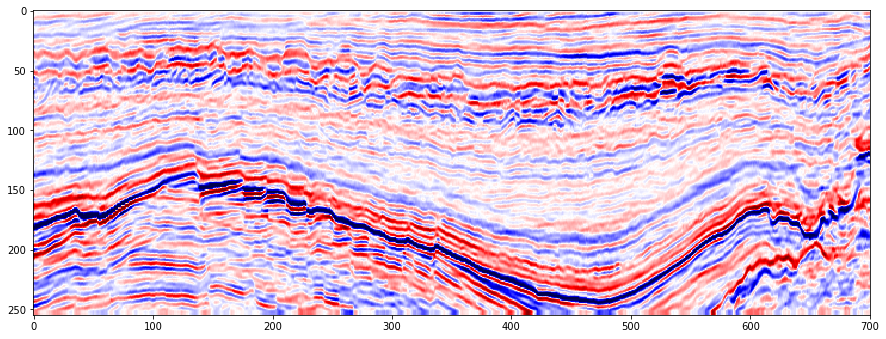

In [ ]:
inline = 90 
fig = plt.figure(figsize=(15,15))
plt.imshow(real_data[:,:,inline],cmap='seismic',interpolation='none')
plt.show()

Ok, that's the slice that we want to test using our last trained model.

Now, let's define our Unet again :

In [ ]:
#https://github.com/milesial/Pytorch-UNet/

import torch.nn.functional as F
import torch.nn as nn
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)        

In [ ]:
num_classes = 2

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes=num_classes).to(device)
model.to(device)


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

---

Great!

Do you still keep your last episode trained model? (*sigh*) I bet its a no.

So, go ahead use this one...

In [ ]:
!gdown "https://drive.google.com/uc?id=1ExzNIC1w3EmdzmVc2ugPceti9w0PE6I6"

Downloading...
From: https://drive.google.com/uc?id=1ExzNIC1w3EmdzmVc2ugPceti9w0PE6I6
To: /content/model.ckpt
124MB [00:00, 144MB/s]


And let's load the weight to our model.

In [ ]:
model.load_state_dict(torch.load('model.ckpt'))

<All keys matched successfully>

# **Predicting Real Data**

Now let's predict these data.

In [ ]:
import numpy as np
from torch.utils.data import DataLoader
import cv2

from pytorch_toolbelt.inference.tiles import ImageSlicer, TileMerger
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image, to_numpy


img = real_data[:,:,inline].astype('float32')  
model.eval()

tiler = ImageSlicer(img.shape, tile_size=(128, 128), tile_step=(64, 64))
merger = TileMerger(tiler.target_shape, 1, tiler.weight)

tiles = [tile for tile in tiler.split(img[:, :, None])]

for tiles_batch, coords_batch in DataLoader(list(zip(tiles, tiler.crops)), batch_size=1):
    tiles_batch = tiles_batch.permute(0, 3, 1, 2)
    output=model(tiles_batch.to(device))
    pred_batch=output.data.max(1)[1]
    merger.integrate_batch(pred_batch, coords_batch)
merged_mask = np.moveaxis(to_numpy(merger.merge()), 0, -1).astype(np.uint8)
merged_mask = tiler.crop_to_orignal_size(merged_mask)
merged_mask=merged_mask[:,:,0]

Visualize the result..

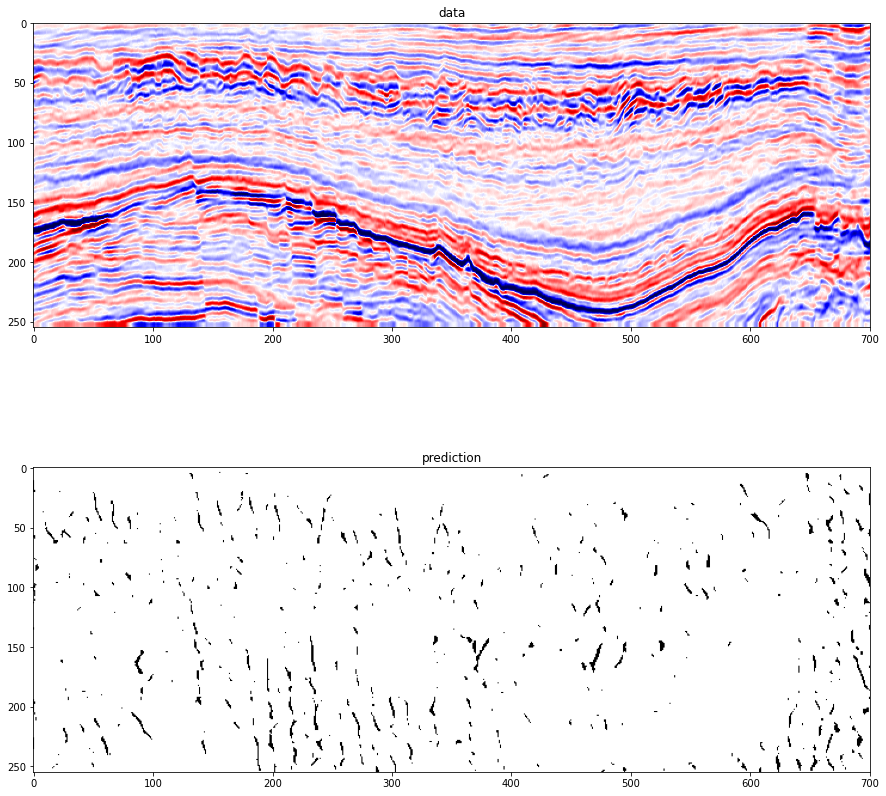

In [ ]:
fig, ax = plt.subplots(2,1, sharey=True, figsize=(15,15))
ax[0].imshow(img, cmap='seismic')
ax[1].imshow(merged_mask, cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('prediction')
plt.show()

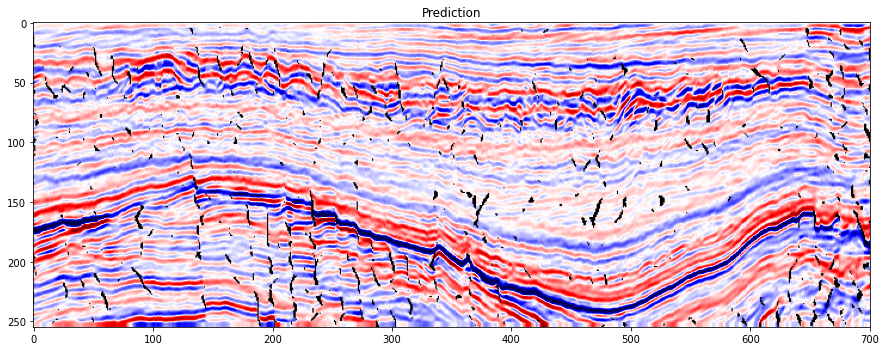

In [ ]:
inline=50
mask_label = merged_mask.copy()
mask_label = np.zeros(merged_mask.shape + (4,))
mask_label[:, :, 3] = merged_mask

fig = plt.figure(figsize=(15,15))

plt.imshow(img, cmap='seismic')
plt.imshow(mask_label)
plt.title('Prediction')
plt.show()

IT'S HORRIBLE AS EXPECTED! HAHA!

Though, some fault can be detected, most place, especially from noisy area still predicted as a fault.

(then again, interpretation is subjective sometimes, I might be wrong which one is the real fault)

Let's retrain our model with sample from this data see if we can make the model to learn new variation of faults from this data.

---

# **Retraining Data**

Now, let's use the one from the training cube.

In [ ]:
train_data = np.load('/content/data/train/train_seismic.npy').transpose(2, 1, 0)

Get two slices and save it.

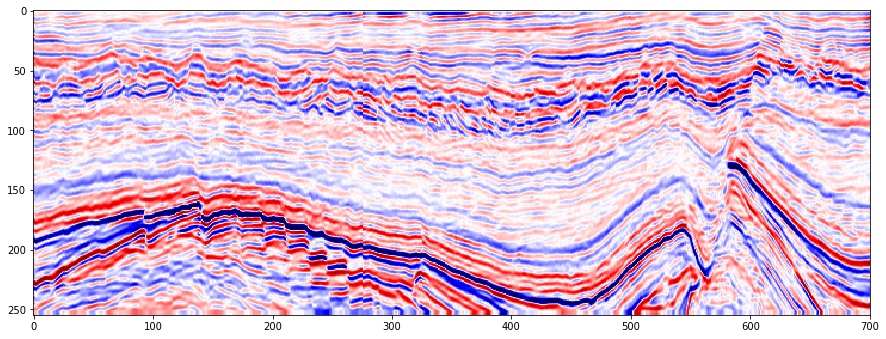

In [ ]:
inline = 0 
fig = plt.figure(figsize=(15,15))
plt.imshow(train_data[:,:,inline],cmap='seismic',interpolation='none')
plt.show()

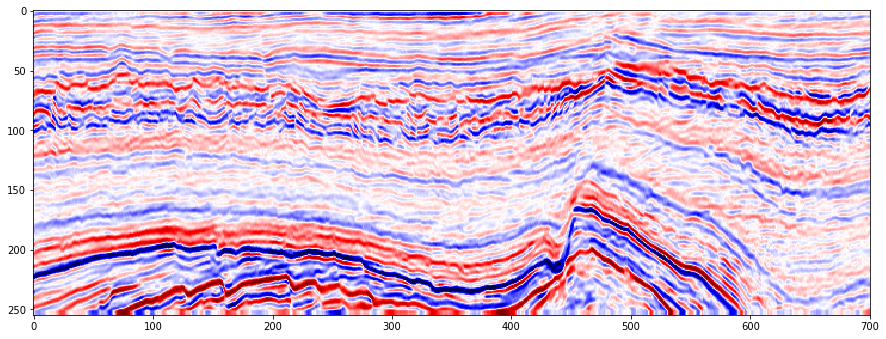

In [ ]:
inline = 150 
fig = plt.figure(figsize=(15,15))
plt.imshow(train_data[:,:,inline],cmap='seismic',interpolation='none')
plt.show()

In [ ]:
inline = 0
plt.imsave("seisF3_%05d"%inline+'.png',train_data[:,:,inline],cmap='seismic')

In [ ]:
inline = 150
plt.imsave("seisF3_%05d"%inline+'.png',train_data[:,:,inline],cmap='seismic')

*But, where's the label?*

Now that is the one that you have to make.

Easiest method is just draw ourselves some fault, save it as image then read it back into numpy array using `imread`.

It's really simple on paint.NET: make new layer, draw the fault, then save as jpg.



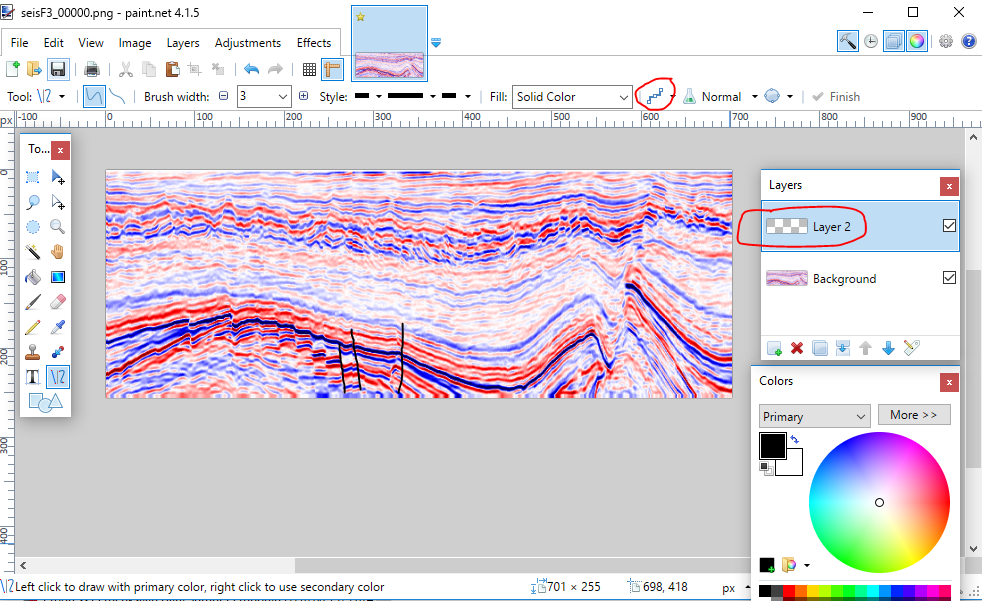

Now, after draw let's use that label drawing. 

You can upload it on google drive then download using `gdown` or just use upload button on the left.


In [ ]:
!gdown "https://drive.google.com/uc?id=1az0gah44asatdvD3HXzK_WxA8RY7LzE6"
!gdown "https://drive.google.com/uc?id=11eZ-CfRM-S9jACILlq7sVHwUAOcCWL_k"

Downloading...
From: https://drive.google.com/uc?id=1az0gah44asatdvD3HXzK_WxA8RY7LzE6
To: /content/faulF3_00000_2.jpg
100% 14.9k/14.9k [00:00<00:00, 29.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=11eZ-CfRM-S9jACILlq7sVHwUAOcCWL_k
To: /content/faulF3_00150.jpg
100% 12.2k/12.2k [00:00<00:00, 10.7MB/s]


Now, we use the first slice for training data.

In [ ]:
train_slice = train_data[:,:,0].copy()

In [ ]:
train_label = cv2.imread('faulF3_00000_2.jpg',0)     #loading images into numpy array
train_label = (np.round(1-train_label/255)).astype('int32')   #convert it into label format, 0=no fault, 1=fault


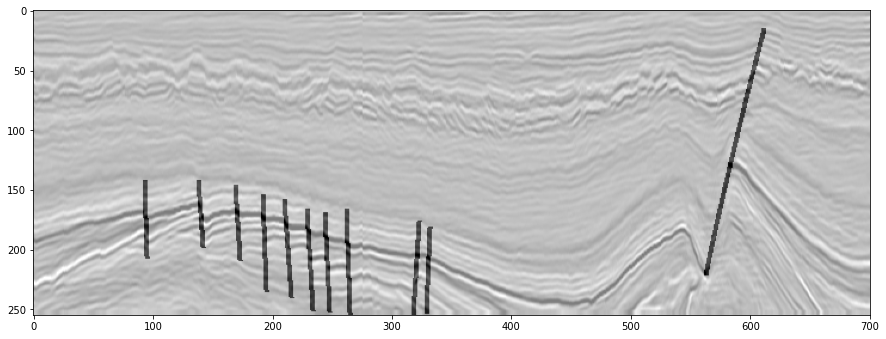

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.imshow(train_slice[:,:], cmap='gray')
plt.imshow(train_label[:,:],cmap='Greys',  alpha=0.5)
plt.show()

.. and the other slice for the test data.

In [ ]:
test_slice = train_data[:,:,150].copy()

In [ ]:
test_label = cv2.imread('faulF3_00150.jpg',0)
test_label = (np.round(1-test_label/255)).astype('int32') 

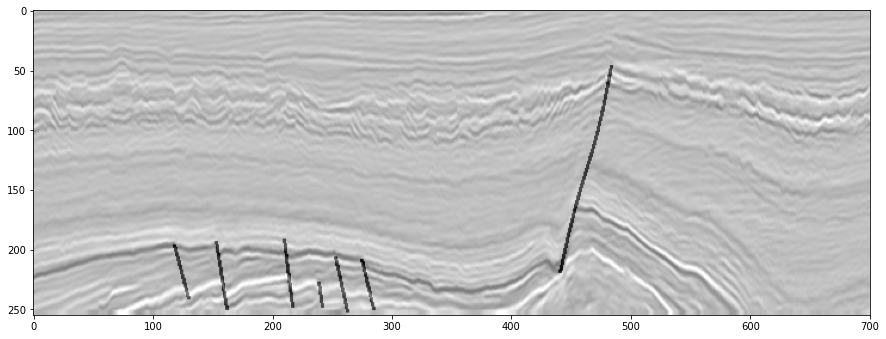

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.imshow(test_slice, cmap='gray')
plt.imshow(test_label, cmap='Greys',  vmin=0, vmax=1, alpha=0.5)
plt.show()

Great.

Now let's make the dataset!

with this limited data, we can use augmentation to make "new" data for our model to learn.

In [ ]:
class seisdataset_train(Dataset):
    def __init__(self, X, y, num_sampel=100):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')
        self.n_sample = num_sampel
        self.aug = A.Compose([             
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=0.30, rotate_limit=30) ,                 
            #A.HorizontalFlip(p=0.2),                  
            A.RandomCrop(p=1, height=128, width=128),
        ])

    def __len__(self):
        return self.n_sample
    
    def __getitem__(self,index):
        
        data = self.X
        label = self.y
        data_aug = self.aug(image=data, mask=label)
        data, label = data_aug['image'], data_aug['mask']          
        return data[None,:,:], label

Now let's test our dataset if it is working as expected.

In [ ]:
train_data = seisdataset_train(train_slice, train_label, num_sampel=50)

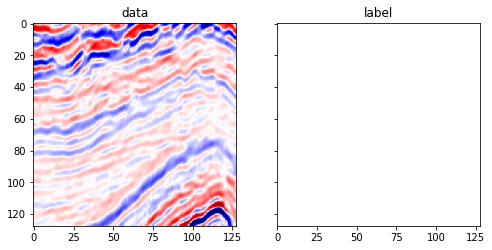

In [ ]:
no_sample = 50
data_get = train_data[no_sample]
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,8))
ax[0].imshow(data_get[0][0,:,:], cmap='seismic')
ax[1].imshow(data_get[1], cmap='Greys')
ax[0].set_title('data')
ax[1].set_title('label')
plt.show()

.. and just like the previous tutorial, let's patch our test slice and make the dataset class.

In [ ]:
ps = 128 #patch size
lx = int(np.ceil(test_slice.shape[0]/ps)*np.ceil(test_slice.shape[1]/ps)) 
data_test_p = np.zeros([ps,ps,lx],dtype='float32')
label_test_p = np.zeros([ps,ps,lx],dtype='float32')

In [ ]:
xx = 0
for i in range(int(np.ceil(test_slice.shape[0]/ps))):
  for j in range(int(np.ceil(test_slice.shape[1]/ps))):
    if i==int(np.ceil(test_slice.shape[0]/ps))-1 and j==int(np.ceil(test_slice.shape[1]/ps))-1:
      data_test_p[:,:,xx] = test_slice[test_slice.shape[0]-ps:,test_slice.shape[1]-ps:]
      label_test_p[:,:,xx] = test_label[test_slice.shape[0]-ps:,test_slice.shape[1]-ps:]      
    elif i==int(np.ceil(test_slice.shape[0]/ps))-1:
      data_test_p[:,:,xx] = test_slice[test_slice.shape[0]-ps:,j*ps:j*ps+ps]
      label_test_p[:,:,xx] = test_label[test_slice.shape[0]-ps:,j*ps:j*ps+ps]
    elif j==int(np.ceil(test_slice.shape[1]/ps))-1: 
      data_test_p[:,:,xx] = test_slice[i*ps:i*ps+ps,test_slice.shape[1]-ps:]
      label_test_p[:,:,xx] = test_label[i*ps:i*ps+ps,test_slice.shape[1]-ps:]
    else:
      data_test_p[:,:,xx] = test_slice[i*ps:i*ps+ps,j*ps:j*ps+ps]
      label_test_p[:,:,xx] = test_label[i*ps:i*ps+ps,j*ps:j*ps+ps]
    xx=xx+1
data_test_p.shape

(128, 128, 12)

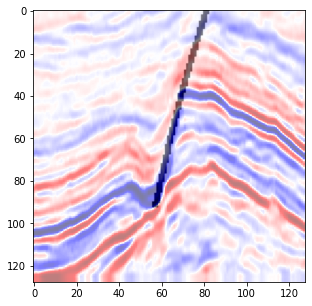

In [ ]:
inline=9
fig = plt.figure(figsize=(5,5))
plt.imshow(data_test_p[:,:,inline], cmap='seismic')
plt.imshow(label_test_p[:,:,inline],cmap='Greys',  vmin=0, vmax=1, alpha=0.5)
plt.show()

In [ ]:
class seisdataset_test(Dataset):
    def __init__(self, X, y, training=True):
        super().__init__()
        self.X = X.astype('float32')
        self.y = y.astype('float32')

    def __len__(self):
        return self.X.shape[2]

    def __getitem__(self,index):
        data = self.X[:,:,index]
        label = self.y[:,:,index]
        return data[None,:,:], label

---

After the data handling part ready, Now..

Let's put some parameters for our training..

In [ ]:
batch_size = 8        # 
num_epochs = 50      # its how many times the model learning from all data being fed 
num_classes = 2       # its a binary classification, fault/no fault, so its 2.
learning_rate = 0.001 # pretty common things on optimization/inversion problems (especially those who know geophysics)
                      # larger learning rate means faster to converge but you won't find the global optimum and opposite

get the dataset into loader..

In [ ]:
def get_data_loaders(batch_size):
    train_data = seisdataset_train(train_slice, train_label, num_sampel=150)
    test_data = seisdataset_test(data_test_p, label_test_p)
    
    train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(dataset = test_data, batch_size = 12, shuffle=False, drop_last=True)
    return train_loader,test_loader

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_loader,test_loader=get_data_loaders(batch_size)

..choose the loss function and optimization algorithm..

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

Some empty variable to put our metric, and then..

In [ ]:
train_losses = []
valid_losses = []
train_F1 = []
test_F1 = []
train_acc = []
test_acc = []
F1_old = 0.0

.. retrain our model!

In [ ]:
for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    F1_train = 0.0
    acc_train = 0.0
    F1_test = 0.0
    acc_test = 0.0    
    model.train()
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        #print(label.shape)
        #print(pred.shape)
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='binary',zero_division=0)   
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        F1_train += f1s
        acc_train += acc

    model.eval()
    for data, label in test_loader:
        
        data = data.to(device)
        label = label.to(device)
        output = model(data.float())
        pred = output.data.max(1)[1].cpu().numpy()[:, :, :]
        loss = criterion(output, label.long())
        acc = accuracy_score(label.cpu().numpy().flatten(), pred.flatten())
        f1s = f1_score(label.cpu().numpy().flatten(), pred.flatten(),average='binary',zero_division=0)     

        valid_loss += loss.item() * data.size(0)
        F1_test += f1s
        acc_test += acc




    train_loss = train_loss/len(train_loader.sampler)
    F1_train = F1_train/len(train_loader.sampler)*batch_size
    acc_train = acc_train/len(train_loader.sampler)*batch_size    
    valid_loss = valid_loss/len(test_loader.sampler)*batch_size
    F1_test = F1_test/len(test_loader.sampler)*batch_size
    acc_test = acc_test/len(test_loader.sampler)*batch_size
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_F1.append(F1_train)
    test_F1.append(F1_test)
    train_acc.append(acc_train)
    test_acc.append(acc_test)      

    if F1_old < F1_test:
      F1_old = F1_test
      torch.save(model.state_dict(), 'model_retrain.ckpt')

    # print
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tF1_train: {:.6f} \tF1_test: {:.6f}'.format(
        epoch, train_loss, valid_loss, F1_train, F1_test))

Epoch: 1 	Training Loss: 0.057021 	Validation Loss: 0.262307 	F1_train: 0.407189 	F1_test: 0.248389
Epoch: 2 	Training Loss: 0.027667 	Validation Loss: 0.243492 	F1_train: 0.729061 	F1_test: 0.233333
Epoch: 3 	Training Loss: 0.020867 	Validation Loss: 0.264830 	F1_train: 0.809803 	F1_test: 0.249264
Epoch: 4 	Training Loss: 0.011286 	Validation Loss: 0.264877 	F1_train: 0.861333 	F1_test: 0.257357
Epoch: 5 	Training Loss: 0.009648 	Validation Loss: 0.269177 	F1_train: 0.878234 	F1_test: 0.241242
Epoch: 6 	Training Loss: 0.008971 	Validation Loss: 0.286251 	F1_train: 0.894637 	F1_test: 0.243853
Epoch: 7 	Training Loss: 0.015532 	Validation Loss: 0.288492 	F1_train: 0.842631 	F1_test: 0.183525
Epoch: 8 	Training Loss: 0.008916 	Validation Loss: 0.279613 	F1_train: 0.885918 	F1_test: 0.241058
Epoch: 9 	Training Loss: 0.007166 	Validation Loss: 0.297154 	F1_train: 0.896848 	F1_test: 0.212906
Epoch: 10 	Training Loss: 0.005027 	Validation Loss: 0.307595 	F1_train: 0.927505 	F1_test: 0.225250

# **Results**

Let's load our model at its best state.

In [ ]:
model.load_state_dict(torch.load('model_retrain.ckpt'))

<All keys matched successfully>

In [ ]:
print('best F1 Test :', F1_old)

best F1 Test : 0.2695526695526696


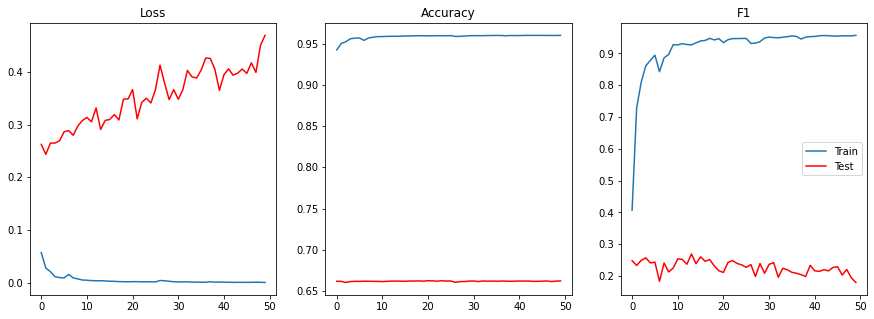

In [ ]:
fig2, ax = plt.subplots(1,3,  figsize=(15,5))
ax[0].plot(train_losses)
ax[1].plot(train_acc)
ax[2].plot(train_F1)
ax[0].plot(valid_losses,'-r')
ax[1].plot(test_acc,'-r')
ax[2].plot(test_F1,'-r')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[2].set_title('F1')
ax[2].legend(("Train", "Test"))
plt.show()

Yikes, the score and the gaps not pretty..

For now let's see if the result is much better than before..

In [ ]:
import numpy as np
from torch.utils.data import DataLoader
import cv2

from pytorch_toolbelt.inference.tiles import ImageSlicer, TileMerger
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image, to_numpy

inline = 90 
img = real_data[:,:,inline].astype('float32')  
model.eval()

tiler = ImageSlicer(img.shape, tile_size=(128, 128), tile_step=(64, 64))
merger = TileMerger(tiler.target_shape, 1, tiler.weight)

tiles = [tile for tile in tiler.split(img[:, :, None])]

for tiles_batch, coords_batch in DataLoader(list(zip(tiles, tiler.crops)), batch_size=1):
    tiles_batch = tiles_batch.permute(0, 3, 1, 2)
    output=model(tiles_batch.to(device))
    pred_batch=output.data.max(1)[1]
    merger.integrate_batch(pred_batch, coords_batch)
merged_mask = np.moveaxis(to_numpy(merger.merge()), 0, -1).astype(np.uint8)
merged_mask = tiler.crop_to_orignal_size(merged_mask)
merged_mask=merged_mask[:,:,0]

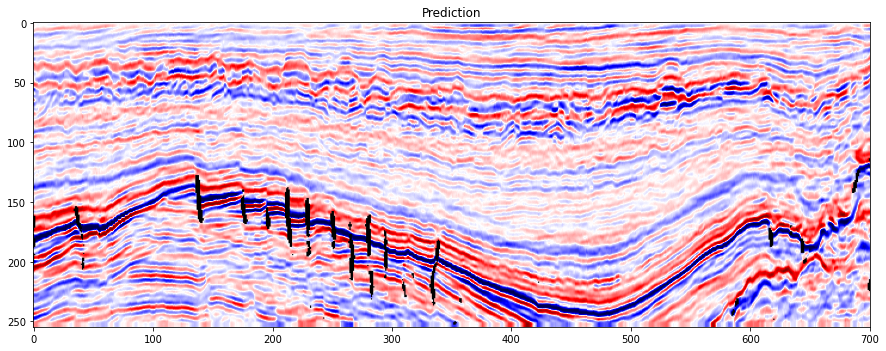

In [ ]:
mask_label = merged_mask.copy()
mask_label = np.zeros(merged_mask.shape + (4,))
mask_label[:, :, 3] = merged_mask

fig = plt.figure(figsize=(15,15))

plt.imshow(img, cmap='seismic')
plt.imshow(mask_label)
plt.title('Prediction')
plt.show()

It much better than before, isn't it? :)

Although, as you can see the some fault can't be detected, especially on noisy areas. 

There are multiple ways improve it such as feeding more training data to the model, precon the data, etc.

Now after learning all of this, what do you think is the best way to make the best result on a new unseen data? Let's say even after we have done everything we can to make the model really good.

...

So that's it.

See you on the next part where we will to try to use the 3D Approach.

# **Exercises**

1. Try to predict on all the test set! Visualize the 3D result! (If you are using jupyter notebook, you can try ipyvolume)
2. Try to add more augmentations! You can also do precondition the data or add noise. (hint: filter, seismic attributes, elastic deformation)
3. Try using another model architecture! there are other famous model like **PSPnet** and **Deeplab** that you can use!
4. Try adding another layer for feature map extraction before using the unet! (FC, ResNet, etc)
